# 1000 Genomes PCA 

## Chris Porras
A notebook to parse 1000 genomes data, convert SNPs to PCA-ble format, and vizualize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.express as px
import seaborn as sns
rc = {'lines.linewidth': 3, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette('colorblind')
%matplotlib inline

In [2]:
# import scikit-allel
import allel
# check which version is installed
print(allel.__version__)

1.2.1


/home/chris/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



### Reading 1000 genomes chr21 genotypes

In [3]:
######### TAKES A LONG TIME #########
callset = allel.read_vcf('../../data/vcf/ALL.chr21.phase3_shapeit2_'
                         +'mvncall_integrated_v5a.20130502.genotypes.vcf.gz')

MemoryError: 

In [6]:
sorted(callset.keys())

['calldata/GT',
 'samples',
 'variants/ALT',
 'variants/CHROM',
 'variants/FILTER_PASS',
 'variants/ID',
 'variants/POS',
 'variants/QUAL',
 'variants/REF']

In [17]:
GT = callset["calldata/GT"]

In [18]:
GT.shape

(1105538, 2504, 2)

In [8]:
ALT = callset["variants/ALT"]

In [9]:
REF = np.array(callset["variants/REF"])

### Construct genotype array

In [24]:
gt_arr = allel.GenotypeArray(GT[:GT.shape[0]//2])

In [28]:
gt_arr

<GenotypeArray shape=(552769, 2504, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/1 1/1 1/1 1/1 1/1 ... 1/1 1/1 1/1 1/1 1/1

In [25]:
allele_counts = gt_arr.count_alleles()

In [26]:
allele_counts

<AlleleCountsArray shape=(552769, 6) dtype=int32>
5007    1    0    0    0    0
5004    4    0    0    0    0
5007    1    0    0    0    0
...
4997   11    0    0    0    0
5005    3    0    0    0    0
1019 3989    0    0    0    0

In [27]:
deriv_allele_freq = np.mean(gt_arr != 0)
print(deriv_allele_freq)

1.0


In [38]:
deriv_allele_freq = np.mean(gt_arr != 0)
print(deriv_allele_freq)

0.04176071858399886


### Convert binomial SNP coding to monomial with number of variants ( 0 = ref, 1 = var)

In [29]:
samp = GT[:GT.shape[0]//2]

In [31]:
samp[samp==2] = 1

/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



In [32]:
samp[samp==3] = 1

/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



In [33]:
conv = np.sum(samp,axis=2)

MemoryError: 

### Perform PCA on entire sample

In [22]:
from sklearn.decomposition import PCA

In [24]:
######### TAKES FOREVER!! ###########

In [38]:
pca = PCA(n_components=4)
PCs = pca.fit_transform(conv)

In [ ]:
######################################

#### Projections onto PCs

In [121]:
PC1 = conv.T@PCs[:,0]

In [122]:
PC2 = conv.T@PCs[:,1]

In [123]:
PC3 = conv.T@PCs[:,2]

#### Get sample population location

In [285]:
key = pd.read_csv("20130606_g1k.ped", sep='\t')

In [288]:
key.head()

,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0


#### Get indeces of rows for our data in the key

In [ ]:
key_id = key.iloc[:,1]
GT_id = callset["samples"]
idx = []
for i in range(len(key_id)):
    for j in range(len(GT_id)):
        if key_id[i] == GT_id[j]:
            idx += i

In [119]:
pops = key.iloc[idx,6] # populations for our chr21 data

In [178]:
super_pop = pd.read_csv("20131219.superpopulations.tsv", sep='\t')

In [179]:
super_pop

,Description,Population Code
0,East Asian,EAS
1,South Asian,SAS
2,African,AFR
3,European,EUR
4,American,AMR


In [180]:
pop_code = pd.read_csv("20131219.populations.tsv", sep='\t')

In [193]:
# Get indeces of 1000 genomes chr21 samples from key
uni_pops = []
for i in np.unique(pops):
    uni_pops += [np.where(pop_code.iloc[:,1]==i)[0][0]]

In [208]:
pop_arr = np.array(pops)

In [221]:
for i in range(len(np.unique(pops))):
    pop_arr[np.where(pops == np.unique(pops)[i])[0]] = np.array(pop_code.iloc[uni_pops,2])[i]

#### Pull out indeces by superpopulation

In [263]:
AFR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AFR")[0][0]])[0]
AMR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AMR")[0][0]])[0]
EAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EAS")[0][0]])[0]
EUR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EUR")[0][0]])[0]
SAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="SAS")[0][0]])[0]

#### Vizualize by superpopulation

In [137]:
pops_col = np.array(pops)

In [227]:
col_pal = np.arange(len(np.unique(pop_arr)))
for i in col_pal:
    pops_col[np.where(pop_arr == np.unique(pop_arr)[i])[0]] = col_pal[i]

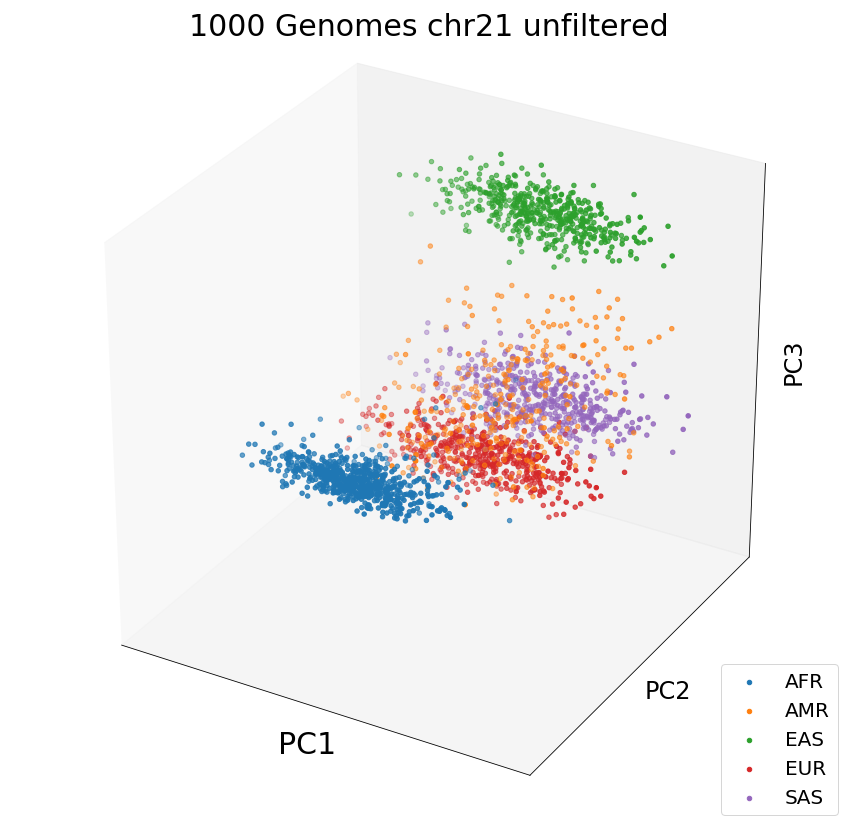

In [364]:
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection ='3d')


samples = [AFR_idx,AMR_idx,EAS_idx,EUR_idx,SAS_idx]
colors = np.arange(len(samples))

for samp in samples:
    ax.scatter3D(PC1[samp],PC2[samp],PC3[samp], label = pop_arr[samp][0])
ax.set_xlabel('PC1', fontsize=30)
ax.set_xticks([])
ax.set_ylabel('PC2',fontsize=24)
ax.set_yticks([])
ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
ax.set_zticks([])
ax.set_title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)
ax.legend(loc =4,prop={'size':20})
fig.savefig("unfiltered_chr21_PCA.jpg",quality=95)

In [ ]:
ax.set_xlabel('PC1', fontsize=30)
ax.set_xticks([])
ax.set_ylabel('PC2',fontsize=24)
ax.set_yticks([])
ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
ax.set_zticks([])
ax.set_title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)
ax.legend(loc =4,prop={'size':20})
fig.savefig("unfiltered_chr21_PCA.jpg",quality=95)

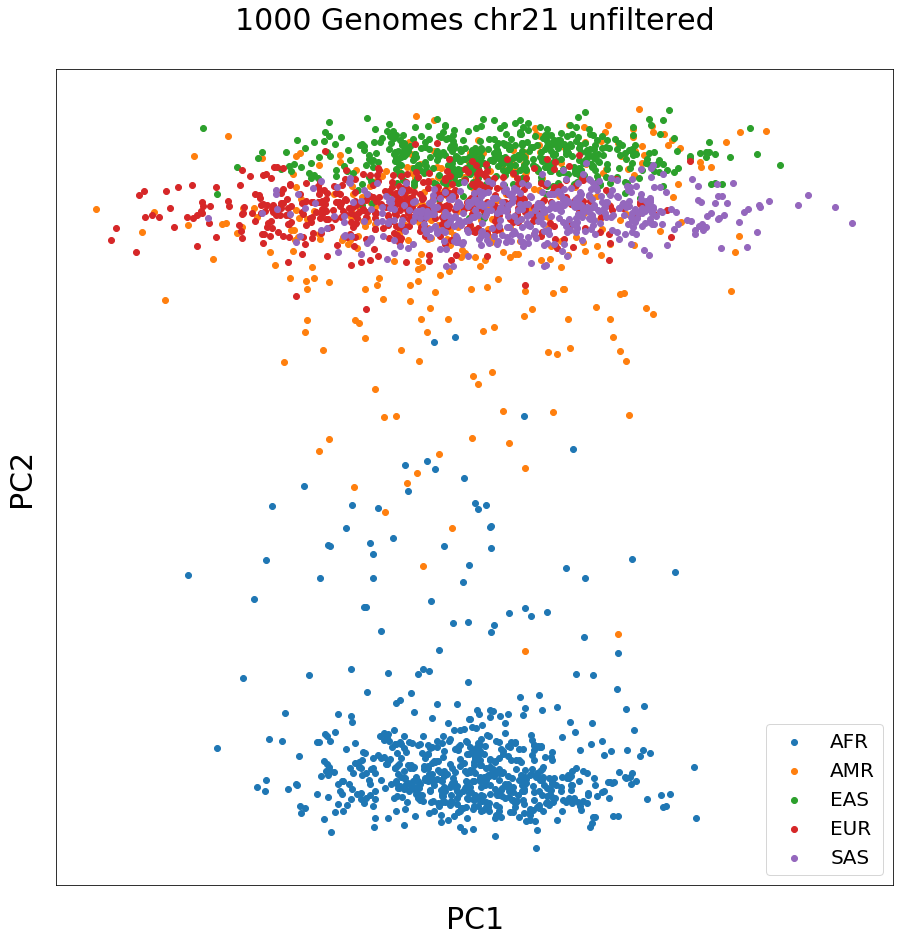

In [377]:
plt.figure(figsize=(15,15))
for samp in samples:
    plt.scatter(PC1[samp],PC2[samp], label = pop_arr[samp][0])
plt.xlabel("PC1",fontsize=30,labelpad=20)
plt.xticks([])
plt.ylabel("PC2",fontsize=30,labelpad=20)
plt.yticks([])
plt.legend(loc =4,prop={'size':20})
plt.title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)

plt.savefig("unfiltered_chr21_PC1PC2.jpg",quality=95)

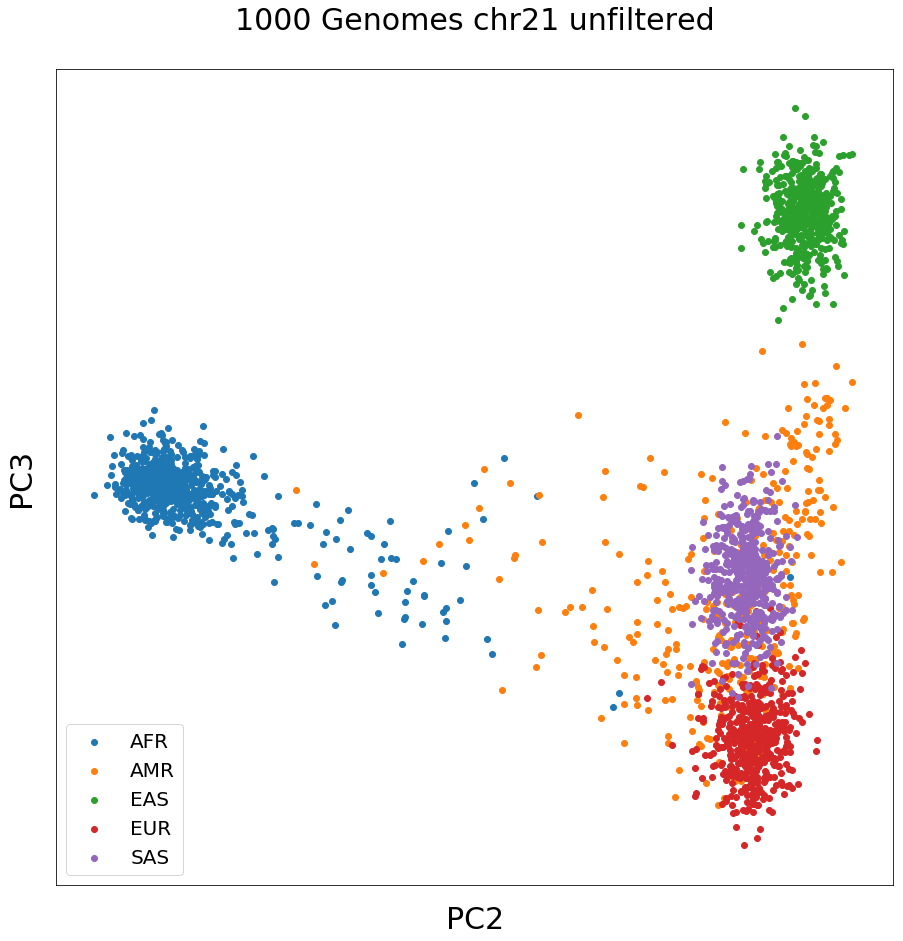

In [378]:
plt.figure(figsize=(15,15))
for samp in samples:
    plt.scatter(PC2[samp],PC3[samp], label = pop_arr[samp][0])
plt.xlabel("PC2",fontsize=30,labelpad=20)
plt.xticks([])
plt.ylabel("PC3",fontsize=30,labelpad=20)
plt.yticks([])
plt.legend(loc =3,prop={'size':20})
plt.title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)

plt.savefig("unfiltered_chr21_PC2PC3.jpg",quality=95)